# Business Case Example - Casey Whorton

+ casey.whorton.waynestate@gmail.com


**Description:** Predict if a client will subscribe to a term-deposit with a predictive model. This will help determine, in advance, clients who will be receptive to term-deposit marketing campaigns.

**Metric:** 𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛 ≔"# Correctly predicted said \"yes\""/"# Correctly predicted said \"yes\" + False Positives" 

+ Questions to drive analysis:
    + What type of customers is a better target?
    + What types of financial activities do they engage in?
    + What are the chances this customer will say “yes”?
    + How long should I wait to contact this customer?
    
**Dataset Link:** https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [21]:
# Import packages

# Normal stuff
import pandas as pd
import numpy as np
import math
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt

# Clustering Stuff
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# ML stuff
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# validate
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

# Data Pipeline

In [22]:
df = pd.read_csv('C:/Users/casey/OneDrive/Desktop/bank/bank-full-LAPTOP-T58B8TK5.csv')

In [23]:
# Data Transformation Pipeline

df['target'] = pd.get_dummies(df.y)['yes']
df['nsf'] = [1 if x <= 0 else 0 for x in df.balance ]
df['pdays_round'] = np.round(df.pdays / 30.0) * 30
df['previous_round'] = np.round(df.previous/7)*7

In [24]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,target,nsf,pdays_round,previous_round
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,261,1,-1,0,unknown,no,0,0,-0.0,0.0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,151,1,-1,0,unknown,no,0,0,-0.0,0.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,76,1,-1,0,unknown,no,0,0,-0.0,0.0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,92,1,-1,0,unknown,no,0,0,-0.0,0.0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,198,1,-1,0,unknown,no,0,0,-0.0,0.0


# Exploratory Data Analysis (EDA)

In [25]:
print('Target % Overall Population: ' + str(np.round(df.target.sum()/len(df),3)*100) + '%')

Target % Overall Population: 11.700000000000001%


In [26]:
# Exploratory Data Analysis

df.isnull().sum().sum()

0

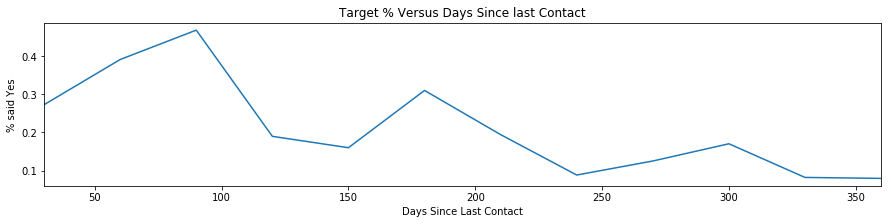

In [27]:
pdays_df = df[['pdays_round','target']].groupby(by='pdays_round').mean()

plt.figure(figsize=(15,3))
plt.title('Target % Versus Days Since last Contact')
pdays_df[15:360].target.plot()
plt.xlabel('Days Since Last Contact')
plt.ylabel('% said Yes')
plt.show()

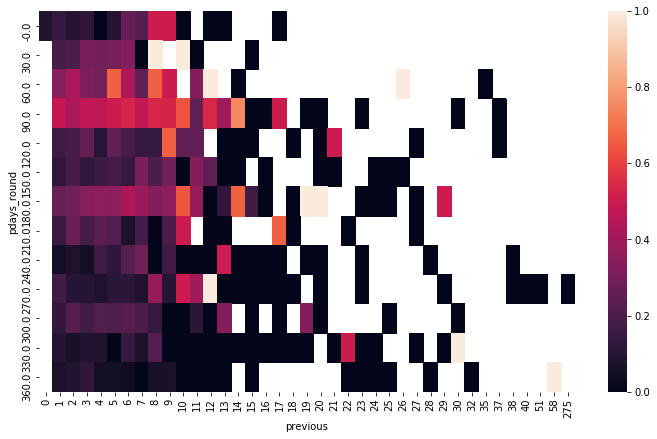

In [28]:
plt.figure(figsize=(12,7))
sns.heatmap(df[df.pdays_round<=360].pivot_table(index = 'pdays_round', columns = 'previous', values = 'target'))

C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\casey\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


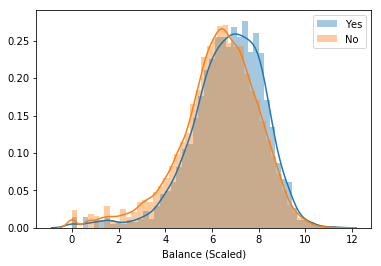

In [29]:
sns.distplot((np.log(df.balance)[(df.nsf != 1) & (df.target == 1)]), label = 'Yes')
sns.distplot((np.log(df.balance)[(df.nsf != 1) & (df.target == 0)]), label = 'No')
plt.xlabel('Balance (Scaled)')
plt.legend()
plt.show()

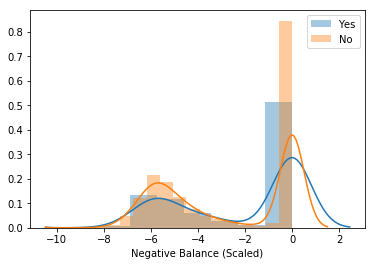

In [30]:
sns.distplot(-1*(np.log(np.abs(df.balance)+1)[(df.nsf == 1) & (df.target == 1)]), label = 'Yes')
sns.distplot(-1*(np.log(np.abs(df.balance)+1)[(df.nsf == 1) & (df.target == 0)]), label = 'No')
plt.xlabel('Negative Balance (Scaled)')
plt.legend()
plt.show()

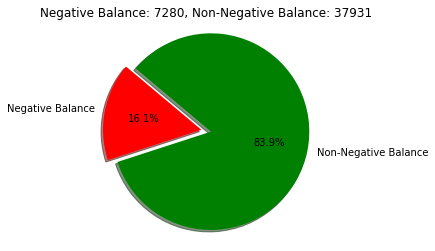

In [31]:
labels = ['Negative Balance', 'Non-Negative Balance']
count_neg = len(df.nsf[df.nsf==1])
count_nonneg = len(df.nsf[df.nsf==0])
sizes = [count_neg,count_nonneg]
colors = ['red','green']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Negative Balance: ' + str(count_neg) + ', Non-Negative Balance: ' +str(count_nonneg))
plt.axis('equal')
plt.show()

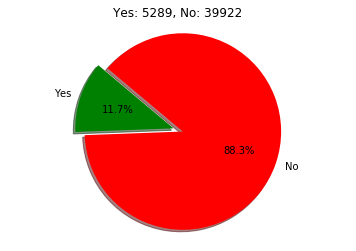

In [32]:
labels = ['Yes', 'No']
count_yes = len(df.target[df.target==1])
count_no = len(df.target[df.target==0])
sizes = [count_yes,count_no]
colors = ['Green','red']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Yes: ' + str(count_yes) + ', No: ' +str(count_no))
plt.axis('equal')
plt.show()


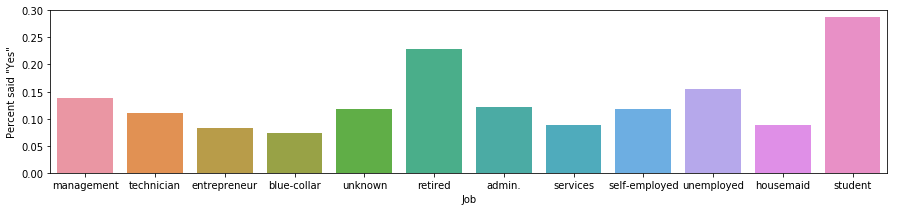

In [33]:
plt.figure(figsize=(15,3))
sns.barplot(x = 'job', y = 'target', data = df, estimator = np.mean, ci=None)
plt.ylabel('Percent said "Yes"')
plt.xlabel('Job')
plt.show()

In [34]:
# Students and Retired said yes more as a percentage

# Prediction of Target


In [35]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,target,nsf,pdays_round,previous_round
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,261,1,-1,0,unknown,no,0,0,-0.0,0.0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,151,1,-1,0,unknown,no,0,0,-0.0,0.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,76,1,-1,0,unknown,no,0,0,-0.0,0.0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,92,1,-1,0,unknown,no,0,0,-0.0,0.0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,198,1,-1,0,unknown,no,0,0,-0.0,0.0


## Downsampling & Train - Test Split

In [36]:
df_yes = df[df.target==1]
df_no = df[df.target==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_no, 
                                 replace=False, 
                                 n_samples=int(df.target.sum()),
                                 random_state=6)
 
df_downsampled = pd.concat([df_majority_downsampled, df_yes])
 
df_downsampled.balance.value_counts()

dfp = df_downsampled

exog_std = dfp[['age','balance','pdays']]
exog_std = pd.DataFrame(columns = ['age','balance','pdays'], data = StandardScaler().fit_transform(np.array(exog_std)))
exog_std.index = dfp.index
endog = dfp.target
exog = pd.concat([
                    pd.get_dummies(dfp.job,prefix='job'),
                    pd.get_dummies(dfp.marital,prefix='mar'),
                    pd.get_dummies(dfp.education,prefix='edu'),
                    pd.get_dummies(dfp.housing,prefix='house'),
                    pd.get_dummies(dfp.loan,prefix='loan'),
                    pd.get_dummies(dfp.default,prefix='def'),
                    pd.get_dummies(dfp.nsf,prefix='nsf'),
                  pd.get_dummies(dfp.previous_round,prefix='prev'),
                  pd.get_dummies(dfp.poutcome,prefix='pout'),exog_std],axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(exog, endog, test_size=.4, random_state=42, stratify = dfp.target)

C:\Users\casey\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\casey\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Grid Search

In [47]:
# random forest
rtree_parms = [{'n_estimators': [5,10,20], 'max_features': [5,10,20], 'max_depth':[5,7,10,15]}]
cldf = RandomForestClassifier()
grid_search = GridSearchCV(cldf, rtree_parms, cv=5, scoring='precision')
grid_search.fit(X_train,y_train)
grid_search.best_params_

{'max_depth': 7, 'max_features': 10, 'n_estimators': 10}

In [52]:
# Be careful running the next one because it takes a reaaally long time to run.

In [48]:
# Gradient Boosting Classifier
gb_parms = [{'n_estimators': [50,100,150,200], 'max_features': [5,10,20],'max_depth':[3,5,7,10,15]}]
cldf = GradientBoostingClassifier()
grid_search = GridSearchCV(cldf, gb_parms, cv=5, scoring='precision')
grid_search.fit(X_train,y_train)
grid_search.best_params_

{'max_depth': 5, 'max_features': 10, 'n_estimators': 50}

## Model Training & Comparison

In [53]:
# Training Data

models = ["Random Forest", "Logistic Regression", "Neural Net", "xgboost"]

model_specs = [
    RandomForestClassifier(max_depth=7, n_estimators=20, max_features = 10),
    LogisticRegression(fit_intercept = True),
    MLPClassifier(solver='lbfgs', alpha=1, random_state=1,
                                     hidden_layer_sizes=[100, 100]),
    GradientBoostingClassifier(max_depth = 5, max_features = 10, n_estimators = 50)
]


for model, clf in zip(models, model_specs):
    clf.fit(X_train, y_train)
    score = precision_recall_fscore_support(y_train, clf.predict(X_train))
    print(score)
    #print(score[3])



(array([0.67389558, 0.74875527]), array([0.79325559, 0.61613615]), array([0.72872032, 0.67600277]), array([3173, 3173], dtype=int64))
(array([0.65287617, 0.6915158 ]), array([0.72612669, 0.61393003]), array([0.68755595, 0.65041736]), array([3173, 3173], dtype=int64))


C:\Users\casey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([0.7804878 , 0.81601877]), array([0.82697762, 0.76741254]), array([0.80306044, 0.79096963]), array([3173, 3173], dtype=int64))
(array([0.67841745, 0.79275905]), array([0.84305074, 0.60037819]), array([0.75182687, 0.68328551]), array([3173, 3173], dtype=int64))


In [54]:
# Testing Data

models = ["Random Forest", "Logistic Regression", "KNN Classifier", "Neural Net", "xgboost"]

model_specs = [
    RandomForestClassifier(max_depth=7, n_estimators=20, max_features = 10),
    LogisticRegression(fit_intercept = True),
    MLPClassifier(solver='lbfgs', alpha=1, random_state=1,
                                     hidden_layer_sizes=[100, 100]),
    GradientBoostingClassifier(max_depth = 5, max_features = 10, n_estimators = 50)
]


for model, clf in zip(models, model_specs):
    clf.fit(X_train, y_train)
    score = precision_recall_fscore_support(y_test, clf.predict(X_test))
    print(score)
    #print(score[3])



(array([0.64168337, 0.7035118 ]), array([0.75661626, 0.57750473]), array([0.69442637, 0.63431093]), array([2116, 2116], dtype=int64))
(array([0.64199134, 0.67065557]), array([0.70085066, 0.60916824]), array([0.67013104, 0.63843487]), array([2116, 2116], dtype=int64))


C:\Users\casey\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([0.63061412, 0.63902439]), array([0.65028355, 0.61909263]), array([0.64029781, 0.62890062]), array([2116, 2116], dtype=int64))
(array([0.63888889, 0.7195122 ]), array([0.7826087 , 0.55765595]), array([0.70348343, 0.62832801]), array([2116, 2116], dtype=int64))


In [55]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,clf.predict(X_test))

array([[1656,  460],
       [ 936, 1180]], dtype=int64)

# Feature Importances

In [56]:
res_df = pd.DataFrame(columns=['Feature','Importance'])
res_df.Feature = exog.columns
res_df.Importance = clf.feature_importances_

In [57]:
res_df2 = res_df.sort_values('Importance',ascending=False).head(10)

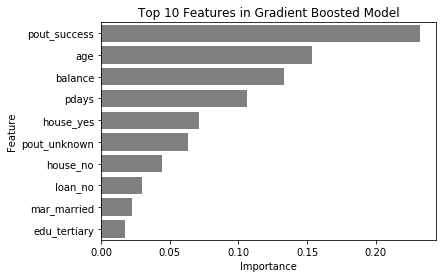

In [58]:
plt.title('Top 10 Features in Gradient Boosted Model')
sns.barplot(y=res_df2.Feature,x= res_df2.Importance,color='grey')
plt.show()

# End